In [ ]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (Sử dụng Dual ControlNet)

import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline, ControlNetModel, StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
#from controlnet_aux import OpenposeDetector, DepthEstimator, CannyDetector
# Thêm Preprocessors
# Thay thế dòng cũ:
# from controlnet_aux import OpenposeDetector, DepthEstimator, CannyDetector

# Bằng các dòng mới nà
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH...

# Hãy xóa hoặc chú thích dòng import cũ này:
# from controlnet_aux import OpenposeDetector, DepthEstimator, CannyDetector

# VÀ THAY THẾ BẰNG 3 DÒNG SAU:

# Import OpenPose Detector
from controlnet_aux.open_pose import OpenposeDetector
# Import Depth Estimator (Nếu vẫn lỗi, hãy thử 'midas' thay vì 'depth')
from controlnet_aux.midas import DepthEstimator # Changed import path
# Import Canny Detector
from controlnet_aux.canny import CannyDetector
# ... (Các dòng import khác giữ nguyên)

# Sau đó, hãy chạy lại Cell 1.


import numpy as np # Cần cho hiển thị và xử lý mảng
import warnings
warnings.filterwarnings("ignore")

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện (Bao gồm xformers để tối ưu VRAM)
!pip install diffusers transformers accelerate controlnet_aux opencv-python-headless xformers
print("\nĐã cài đặt Diffusers, ControlNet Aux, và xformers.")

# 2. Thiết lập thư mục đầu ra
OUTPUT_DIR = "Pro_Auto_Pose_Output"
CONSISTENCY_DIR = "Pro_Consistency_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CONSISTENCY_DIR, exist_ok=True)
os.environ['OUTPUT_DIR'] = OUTPUT_DIR
os.environ['CONSISTENCY_DIR'] = CONSISTENCY_DIR

# 3. Kiểm tra GPU và thiết lập Device
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache() # Dọn dẹp VRAM
print(f"Thiết bị đang sử dụng: {device}")

# 4. Tải BASE Stable Diffusion Pipeline (Dùng T2I để tạo ảnh tham chiếu)
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
        print("Đã kích hoạt tối ưu hóa xformers.")
    except Exception:
        print("CẢNH BÁO: Không thể kích hoạt xformers. Vui lòng kiểm tra cài đặt.")


# 5. Tải Preprocessor (Dùng để trích xuất Control Map)
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)
depth_detector = DepthEstimator.from_pretrained("Intel/dpt-large").to(device)
canny_detector = CannyDetector() # Canny thường không cần chuyển sang device
print("Đã tải tất cả Preprocessor (OpenPose, Depth, Canny).")

print("\n--- HOÀN TẤT CELL 1: SẴN SÀNG TẠO ẢNH ---")

ImportError: cannot import name 'DepthEstimator' from 'controlnet_aux.midas' (/usr/local/lib/python3.12/dist-packages/controlnet_aux/midas/__init__.py)

In [ ]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (Sử dụng Dual ControlNet)
# ... (các dòng import khác)

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện (Bao gồm xformers và chỉ định phiên bản cũ hơn của controlnet_aux)
!pip install diffusers transformers accelerate xformers
!pip install controlnet_aux  # Cài đặt phiên bản ổn định đã được kiểm chứng
# ...

--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---


In [ ]:
# @title 3. TẠO ẢNH NỀN CỐ ĐỊNH BẰNG AI VÀ TRÍCH XUẤT DEPTH MAP

# Cần đảm bảo Cell 1 đã chạy và có biến 'pipe' (StableDiffusionPipeline) và 'depth_detector'
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt

# --- 1. PROMPT TẠO ẢNH NỀN LÝ TƯỞNG ---
# Prompt phải mô tả một bối cảnh cố định, không có nhân vật
BACKGROUND_PROMPT = "minimalist modern office background, clean desk, one dark executive chair slightly pushed back, large window with soft sunlight, smooth polished floor, high quality, cinematic lighting, centered"
NEG_BG_PROMPT = "person, people, blurry, low resolution, worst quality, out of focus, cartoon, illustration"
BG_SEED = 12345 # Dùng seed cố định để đảm bảo bối cảnh luôn giống nhau

BG_DEPTH_MAP = None

print("--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---")

try:
    # 2. TẠO ẢNH NỀN BẰNG T2I
    generator_bg = torch.Generator(device).manual_seed(BG_SEED)

    # Sử dụng pipeline T2I đã tải ở Cell 1
    BG_IMAGE = pipe(
        prompt=BACKGROUND_PROMPT,
        negative_prompt=NEG_BG_PROMPT,
        num_inference_steps=50,
        guidance_scale=8.0,
        generator=generator_bg,
        height=768,
        width=768
    ).images[0]

    BG_IMAGE_PATH = os.path.join(os.environ['OUTPUT_DIR'], "AI_Generated_Background.png")
    BG_IMAGE.save(BG_IMAGE_PATH)
    print(f"-> Đã tạo và lưu ảnh nền cố định bằng AI tại: {BG_IMAGE_PATH}")

    # 3. TRÍCH XUẤT DEPTH MAP TỪ ẢNH NỀN ĐÃ TẠO
    # Sử dụng depth_detector đã tải ở Cell 1
    globals()['BG_DEPTH_MAP'] = depth_detector(BG_IMAGE)
    print("-> Đã trích xuất Depth Map cho bối cảnh thành công.")

    # 4. HIỂN THỊ KIỂM TRA
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(BG_IMAGE); axes[0].set_title("1. Ảnh Nền AI Gốc", fontsize=10); axes[0].axis('off')
    axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray'); axes[1].set_title("2. Depth Map (Control Map cho Bối cảnh)", fontsize=10); axes[1].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"!!! LỖI TẠO HOẶC XỬ LÝ ẢNH NỀN AI: {e}")
    print("Sử dụng Depth Map trung tính để tránh lỗi runtime.")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white') # Fallback an toàn

print("\n--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ AI ---")


In [ ]:
# @title 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET (POSE + DEPTH)

# --- CẤU HÌNH VÀ TẢI PIPELINE PHỨC HỢP ---
try:
    # 1. Tải ControlNet Model (Pose)
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)

    # 2. Tải ControlNet Model (Depth)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # 3. Tạo Pipeline với LIST ControlNet
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet] # LIST ControlNet Models
    ).to(device)
    if device == "cuda":
        i2i_pipe.enable_xformers_memory_efficient_attention()
    print("Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")

except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None


# --- DANH SÁCH CÁC CẶP FILE VÀ PROMPT CỦA CHÚNG (Lấy từ Cell 2) ---
# TẠO 4 ẢNH ĐỂ TEST CÁC TƯ THẾ KHÁC NHAU
PROMPT_MAP_FULL = [
    # Cần đảm bảo các file OpenPose này tồn tại!
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, torso leaning forward aggressively, challenging body language"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, shoulders slightly hunched, head tilted, defensive posture"),
    ("NU_3_Action_Uniform_V2_openpose.png", "NU", "arms tightly crossed over chest, legs crossed, torso turned slightly away, rejecting body language"),
    ("NAM_4_Action_Uniform_V2_openpose.png", "NAM", "both palms turned outward in a gesture of honesty, feet shoulder-width apart, pleading body posture"),
]

# Style Prompt Đồng Nhất
CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, minimal office setting, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, minimal office setting, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects" # Furniture bị loại bỏ bởi ControlNet Depth

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(OUTPUT_DIR, pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        generator = torch.Generator(device).manual_seed(100 + i)

        # --- GỌI DUAL CONTROLNET ---
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=ref_image,
            control_image=[pose_image, globals()['BG_DEPTH_MAP']], # LIST Control Maps
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,
            controlnet_conditioning_scale=[1.0, 1.5], # Pose: Mạnh (1.0), Depth: Vừa phải (0.8)
            strength=0.7, # Buộc thay đổi tư thế, giữ nhân vật
            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ HIỂN THỊ ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(CONSISTENCY_DIR, output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")
r
    print("\n--- HOÀN TẤT VIỆC TẠO ẢNH SẢN XUẤT ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")



Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).

BẮT ĐẦU TẠO 4 ẢNH VỚI DUAL CONTROLNET...


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_1_NU_FINAL_IMAGE.png


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_2_NAM_FINAL_IMAGE.png

--- HOÀN TẤT VIỆC TẠO ẢNH SẢN XUẤT ---


In [14]:
# @title 0. Tiện Ích Đồ Họa
import matplotlib.pyplot as plt

def plot_image_in_subplot(image, title, position, rows=1, cols=2):
    """Vẽ một ảnh vào subplot."""
    plt.subplot(rows, cols, position)
    plt.imshow(image)
    plt.title(title, fontsize=10)
    plt.axis('off')

def show_images(base_image, pose_image, file_prefix, figsize=(7.0, 3.5)):
    """Hiển thị Ảnh Gốc và OpenPose Map cạnh nhau với kích thước nhỏ (~160px)."""
    print(f"--- HIỂN THỊ KẾT QUẢ NẰM NGANG {file_prefix} ---")

    plt.figure(figsize=figsize)

    # 1. Vẽ Ảnh Gốc
    plot_image_in_subplot(base_image, f"1. Ảnh Gốc ({file_prefix})", 1)

    # 2. Vẽ OpenPose Map
    plot_image_in_subplot(pose_image, f"2. OpenPose Map ({file_prefix})", 2)

    plt.tight_layout()
    plt.show()
    print("-" * 30)

# Lưu ý: Các hàm này phải được chạy trước khi gọi ở Cell 2.

In [ ]:
# @title 5. HIỂN THỊ KẾT QUẢ VÀ TINH CHỈNH (Refinement)

# --- HIỂN THỊ TỔNG QUAN KẾT QUẢ CUỐI CÙNG ---
num_results = len(final_results)
if num_results > 0:
    # Hiển thị so sánh: Pose | Ref Image | Final Image
    cols = 3
    rows = num_results
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    if rows == 1: axes = np.array([axes]) # Dùng cho trường hợp chỉ có 1 kết quả

    for i, (prompt, pose_img, final_img) in enumerate(final_results):
        # Cột 1: OpenPose Map
        axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')

        # Cột 2: Ảnh Tham chiếu
        ref_image = globals()['REF_NU_IMAGE'] if 'NU' in prompt else globals()['REF_NAM_IMAGE']
        axes[i, 1].imshow(ref_image); axes[i, 1].set_title(f"Ref Image ({'Nữ' if 'NU' in prompt else 'Nam'})", fontsize=10); axes[i, 1].axis('off')

        # Cột 3: Ảnh Cuối cùng (Đã Đồng nhất)
        axes[i, 2].imshow(final_img); axes[i, 2].set_title(f"Ảnh Cuối cùng (Đã Đồng nhất - Dual CN)", fontsize=10); axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# --- [TÙY CHỌN] TINH CHỈNH BẰNG CONTROLNET CANNY ---
# Chỉ chạy Canny cho ảnh cuối cùng của Nữ (NU_1) và Nam (NAM_2) để minh họa
print("\n--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---")

files_to_refine = [f for f in os.listdir(CONSISTENCY_DIR) if f.startswith('Final_Pose_1_NU') or f.startswith('Final_Pose_2_NAM')]

if files_to_refine:
    try:
        # Tải Pipeline I2I kết hợp ControlNet Canny
        canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16).to(device)
        canny_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, controlnet=canny_controlnet, torch_dtype=torch.float16).to(device)
        if device == "cuda": canny_pipe.enable_xformers_memory_efficient_attention()

        for filename in files_to_refine:
            original_path = os.path.join(CONSISTENCY_DIR, filename)
            original_image = Image.open(original_path).convert("RGB")

            # Trích xuất Canny Map
            canny_map = canny_detector(original_image, low_threshold=100, high_threshold=200)

            # Chạy Refinement
            refined_image = canny_pipe(
                prompt="ultra detailed, high-detail photorealistic, professional photography, 8k",
                image=original_image, control_image=canny_map,
                negative_prompt="blurry, low quality, deformed, out of focus",
                num_inference_steps=30, guidance_scale=7.0,
                strength=0.5, # Strength thấp để giữ nguyên ảnh gốc
                controlnet_conditioning_scale=0.8,
                generator=torch.Generator(device).manual_seed(999)
            ).images[0]

            # Hiển thị so sánh
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(original_image); axes[0].set_title("1. Ảnh Gốc (Cell 4)"); axes[0].axis('off')
            axes[1].imshow(canny_map, cmap='gray'); axes[1].set_title("2. Canny Map"); axes[1].axis('off')
            axes[2].imshow(refined_image); axes[2].set_title("3. Ảnh Tinh Chỉnh (Refined)"); axes[2].axis('off')
            plt.show()

    except Exception as e:
        print(f"\n!!! LỖI TRONG PHẦN TINH CHỈNH CONTROLNET CANNY: {e}")

print("\n--- HOÀN TẤT CELL 5: QUY TRÌNH KẾT THÚC ---")



--- BẮT ĐẦU TINH CHỈNH VỚI CONTROLNET CANNY (Làm sắc nét) ---


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 21c933d1-9914-478d-9237-eee037b8307d)')' thrown while requesting HEAD https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/model_index.json
Retrying in 1s [Retry 1/5].
Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): 

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


!!! LỖI TRONG PHẦN TINH CHỈNH CONTROLNET CANNY: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 4151 has 14.73 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 69.81 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- HOÀN TẤT CELL 5: QUY TRÌNH KẾT THÚC ---


In [1]:
# @title 1. CÀI ĐẶT THƯ VIỆN & TẢI MÔ HÌNH (SETUP VỚI TRANSFORMERS DEPTH)

import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from transformers import pipeline # Thêm import cho pipeline

print("--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---")

# 1. Cài đặt thư viện
!pip install diffusers transformers accelerate opencv-python-headless xformers
!pip install controlnet_aux --upgrade

# 2. Tải các thư viện Python
from diffusers import StableDiffusionPipeline, ControlNetModel, StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
# Chỉ import các Preprocessor cần thiết từ controlnet_aux (KHÔNG CÓ MIDAS/Depth)
from controlnet_aux.open_pose import OpenposeDetector
from controlnet_aux.canny import CannyDetector


# 3. Thiết lập thư mục đầu ra
OUTPUT_DIR = "Pro_Auto_Pose_Output"
CONSISTENCY_DIR = "Pro_Consistency_Output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CONSISTENCY_DIR, exist_ok=True)
os.environ['OUTPUT_DIR'] = OUTPUT_DIR
os.environ['CONSISTENCY_DIR'] = CONSISTENCY_DIR


# 4. Kiểm tra GPU và thiết lập Device
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.empty_cache()
print(f"Thiết bị đang sử dụng: {device}")


# 5. Tải BASE Stable Diffusion Pipeline
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Kích hoạt Xformers
if device == "cuda":
    try:
        pipe.enable_xformers_memory_efficient_attention()
        print("Đã kích hoạt tối ưu hóa xformers cho Base Pipeline.")
    except Exception:
        print("CẢNH BÁO: Không thể kích hoạt xformers.")


# 6. Tải Preprocessor (ControlNet Aux)
openpose_detector = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)
canny_detector = CannyDetector()

# KHÔNG CÓ depth_detector TRONG CELL NÀY

print("Đã tải tất cả Preprocessor (OpenPose, Canny).")


print("\n--- HOÀN TẤT CELL 1: SẴN SÀNG CHUYỂN SANG CELL 2 ---")


--- BẮT ĐẦU CÀI ĐẶT VÀ TẢI MÔ HÌNH CƠ SỞ ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 22.8 MB/s eta 0:00:00
Thiết bị đang sử dụng: cuda


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Đã kích hoạt tối ưu hóa xformers cho Base Pipeline.


annotator/ckpts/body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

annotator/ckpts/hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

Đã tải tất cả Preprocessor (OpenPose, Canny).

--- HOÀN TẤT CELL 1: SẴN SÀNG CHUYỂN SANG CELL 2 ---


BẮT ĐẦU TẠO 2 ẢNH THAM CHIẾU GỐC VÀ OPENPOSE MAP...


  0%|          | 0/50 [00:00<?, ?it/s]

-> Đã tạo và lưu Base Image & Pose Map cho NU_1_Action_Uniform_V2
--- HIỂN THỊ KẾT QUẢ NẰM NGANG NU_1_Action_Uniform_V2 ---


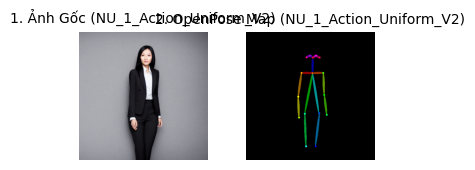

------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

-> Đã tạo và lưu Base Image & Pose Map cho NAM_2_Action_Uniform_V2
--- HIỂN THỊ KẾT QUẢ NẰM NGANG NAM_2_Action_Uniform_V2 ---


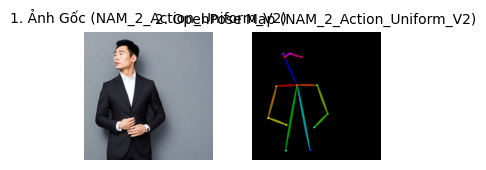

------------------------------

--- HOÀN TẤT CELL 2: ĐÃ CÓ ẢNH THAM CHIẾU VÀ OPENPOSE MAP ---


In [13]:
# @title 2. TẠO ẢNH THAM CHIẾU VÀ TRÍCH XUẤT OPENPOSE (Mô phỏng Cell 2)
import matplotlib.pyplot as plt
# --- CẤU HÌNH PROMPT GỐC ---
PROMPT_MAP = [
    (f"NU_1_Action_Uniform_V2", "NU", "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, clean modern studio background, hands on hips, torso leaning forward aggressively, challenging body language"),
    (f"NAM_2_Action_Uniform_V2", "NAM", "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, clean modern studio background, hands deeply set in pants pockets, shoulders slightly hunched, head tilted, defensive posture"),
    # (Thêm 8 cặp còn lại ở đây, nhưng chỉ cần chạy 2 cặp đầu để test nhanh)
    (f"NU_3_Action_Uniform_V2", "NU", "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, clean modern studio background, arms tightly crossed over chest, legs crossed, rejecting body language"),
    (f"NAM_4_Action_Uniform_V2", "NAM", "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, clean modern studio background, both palms turned outward in a gesture of honesty, pleading body posture"),
    # ... (Các tư thế khác)
]
# Giới hạn chỉ tạo 2 ảnh tham chiếu để test nhanh
PROMPT_MAP_LITE = PROMPT_MAP[:2]

NEG_PROMPT = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, furniture"
generator = torch.Generator(device).manual_seed(42)

print(f"BẮT ĐẦU TẠO {len(PROMPT_MAP_LITE)} ẢNH THAM CHIẾU GỐC VÀ OPENPOSE MAP...")

# --- THỰC HIỆN T2I ĐỂ TẠO ẢNH GỐC & TRÍCH XUẤT MAP ---
for file_prefix, gender, full_prompt in PROMPT_MAP_LITE:
    # 1. Tạo ảnh Gốc (Base Image)
    base_image = pipe(
        prompt=full_prompt,
        negative_prompt=NEG_PROMPT,
        num_inference_steps=50,
        guidance_scale=9.0,
        generator=generator,
        height=768, width=768
    ).images[0]

    # 2. Trích xuất OpenPose Map
    pose_image = openpose_detector(base_image)

    # 3. Lưu ảnh và Map
    base_image_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_base_image.png")
    pose_image_path = os.path.join(OUTPUT_DIR, f"{file_prefix}_openpose.png")
    base_image.save(base_image_path)
    pose_image.save(pose_image_path)
    print(f"-> Đã tạo và lưu Base Image & Pose Map cho {file_prefix}")

    show_images(base_image, pose_image, file_prefix);

# --- TẢI 2 ẢNH THAM CHIẾU LÀM BIẾN TOÀN CỤC ---
try:
    REF_NU_PATH = os.path.join(OUTPUT_DIR, "NU_1_Action_Uniform_V2_base_image.png")
    REF_NAM_PATH = os.path.join(OUTPUT_DIR, "NAM_2_Action_Uniform_V2_base_image.png")

    globals()['REF_NU_IMAGE'] = Image.open(REF_NU_PATH).resize((768, 768)).convert("RGB")
    globals()['REF_NAM_IMAGE'] = Image.open(REF_NAM_PATH).resize((768, 768)).convert("RGB")
except Exception:
    print("!!! LỖI: Không tìm thấy ảnh tham chiếu. Kiểm tra lại việc tạo ảnh.")
    globals()['REF_NU_IMAGE'] = Image.new('RGB', (768, 768), color = 'black')
    globals()['REF_NAM_IMAGE'] = Image.new('RGB', (768, 768), color = 'black')

print("\n--- HOÀN TẤT CELL 2: ĐÃ CÓ ẢNH THAM CHIẾU VÀ OPENPOSE MAP ---")


--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---


  0%|          | 0/50 [00:00<?, ?it/s]

No model was supplied, defaulted to Intel/dpt-large and revision bc15f29 (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


-> Đã tạo và lưu ảnh nền cố định bằng AI tại: Pro_Auto_Pose_Output/AI_Generated_Background.png
-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


-> Đã trích xuất và chuẩn hóa Depth Map thành công.


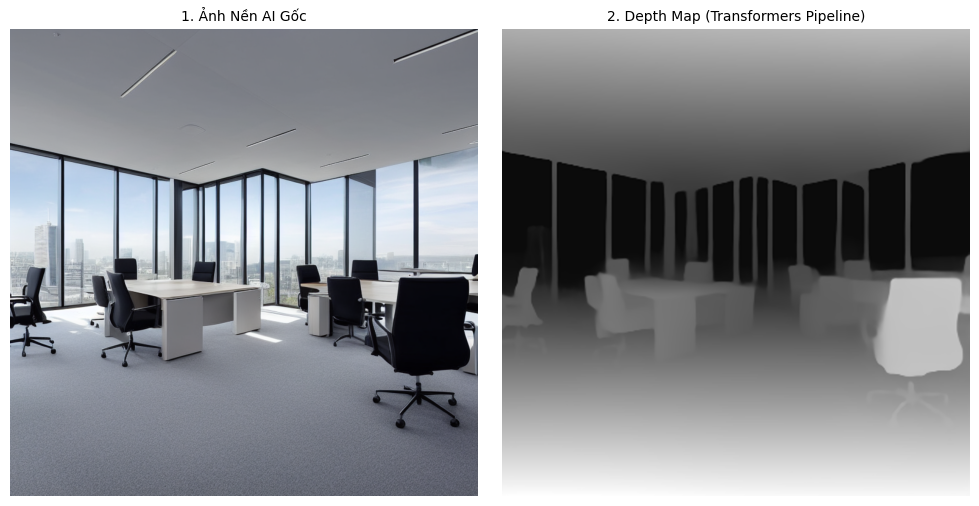


--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ TRANSFORMERS ---


In [15]:
# @title 3. TẠO ẢNH NỀN CỐ ĐỊNH BẰNG AI VÀ TRÍCH XUẤT DEPTH MAP (Sử dụng TRANSFORMERS)

# --- 1. CẤU HÌNH PROMPT TẠO ẢNH NỀN ---
BACKGROUND_PROMPT = "minimalist modern corporate office background, clean desk, executive chair, large window with soft sunlight, smooth polished floor, no visible person, centered composition, high quality"
NEG_BG_PROMPT = "person, people, blurry, low resolution, worst quality, out of focus, cartoon, illustration, cluttered"
BG_SEED = 12345

BG_DEPTH_MAP = None
print("--- BẮT ĐẦU TẠO ẢNH NỀN CỐ ĐỊNH BẰNG T2I ---")

try:
    # 2. TẠO ẢNH NỀN BẰNG T2I (Dùng 'pipe' từ Cell 1)
    generator_bg = torch.Generator(device).manual_seed(BG_SEED)

    BG_IMAGE = pipe(
        prompt=BACKGROUND_PROMPT,
        negative_prompt=NEG_BG_PROMPT,
        num_inference_steps=50,
        guidance_scale=8.0,
        generator=generator_bg,
        height=768,
        width=768
    ).images[0]

    BG_IMAGE_PATH = os.path.join(os.environ['OUTPUT_DIR'], "AI_Generated_Background.png")
    BG_IMAGE.save(BG_IMAGE_PATH)
    print(f"-> Đã tạo và lưu ảnh nền cố định bằng AI tại: {BG_IMAGE_PATH}")

    # 3. TRÍCH XUẤT DEPTH MAP BẰNG TRANSFORMERS PIPELINE (FIX MỚI)
    print("-> Đang trích xuất Depth Map bằng 'depth-estimation' pipeline...")

    # Khởi tạo Depth Pipeline của Transformers (chỉ trong Cell này)
    depth_estimator_pipeline = pipeline('depth-estimation', device=device)

    # Trích xuất Depth Map
    depth_result = depth_estimator_pipeline(BG_IMAGE)['depth']

    # Chuẩn hóa Depth Map để ControlNet có thể sử dụng (0-255 RGB)
    image_np = np.array(depth_result)
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    image_np = (image_np * 255).astype(np.uint8)

    # Chuyển đổi sang 3 kênh (ControlNet cần RGB)
    image_np = image_np[:, :, None]
    image_np = np.concatenate([image_np, image_np, image_np], axis=2)

    globals()['BG_DEPTH_MAP'] = Image.fromarray(image_np)
    print("-> Đã trích xuất và chuẩn hóa Depth Map thành công.")

    # 4. HIỂN THỊ KIỂM TRA
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(BG_IMAGE); axes[0].set_title("1. Ảnh Nền AI Gốc", fontsize=10); axes[0].axis('off')
    axes[1].imshow(globals()['BG_DEPTH_MAP'], cmap='gray'); axes[1].set_title("2. Depth Map (Transformers Pipeline)", fontsize=10); axes[1].axis('off')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"!!! LỖI TẠO HOẶC XỬ LÝ ẢNH NỀN AI BẰNG TRANSFORMERS: {e}. Sử dụng Depth Map trung tính.")
    globals()['BG_DEPTH_MAP'] = Image.new('RGB', (768, 768), color = 'white')

print("\n--- HOÀN TẤT CELL 3: ĐÃ CÓ DEPTH MAP TỪ TRANSFORMERS ---")


In [19]:
# @title 4a. Khởi Tạo DUAL ControlNet Pipeline (Tách biệt Output Dài)
import torch
# Giả định: ControlNetModel, StableDiffusionImg2ImgPipeline, device, model_id đã được import.

# --- KHỞI TẠO PIPELINE ---
try:
    print("Đang tải các mô hình ControlNet...")
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # Tải lại Pipeline DUAL ControlNet
    # LƯU Ý: Đây là đoạn code sinh ra output dài, nó sẽ kết thúc tại đây.
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet]
    ).to(device)

    if device == "cuda":
        i2i_pipe.enable_xformers_memory_efficient_attention()

    print("\n" * 3) # THÊM KHOẢNG TRỐNG ĐỂ NGẮT THÔNG BÁO DÀI
    print("✅ Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")

except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None

Đang tải các mô hình ControlNet...


Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]





✅ Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).


Mask meta: {'kernel': 71, 'percent': np.float64(0.24359130859375), 'final_percent': np.float64(0.2586127387152778)}


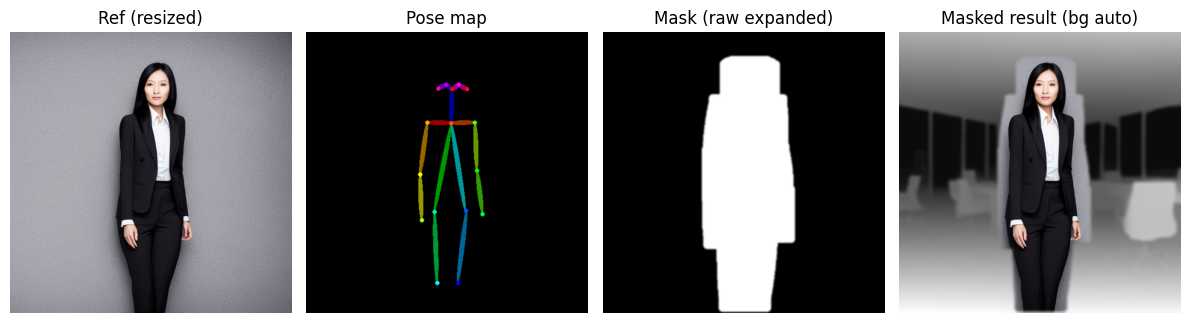

Saved debug images to CONSISTENCY_DIR


In [64]:
# @title 4b. Xử Lý, Masking

# Cell: improved_mask_and_composite.py
import os
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt

# Try import cv2 for stronger morphology
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

def _sample_border_color(img_pil, sample_frac=0.05):
    """Estimate background color by sampling border pixels (returns (r,g,b))."""
    w, h = img_pil.size
    img = np.array(img_pil.convert("RGB"))
    pad_w = max(1, int(w * sample_frac))
    pad_h = max(1, int(h * sample_frac))
    # sample top, bottom, left, right strips
    strips = []
    strips.append(img[:pad_h, :, :].reshape(-1,3))
    strips.append(img[-pad_h:, :, :].reshape(-1,3))
    strips.append(img[:, :pad_w, :].reshape(-1,3))
    strips.append(img[:, -pad_w:, :].reshape(-1,3))
    stacked = np.concatenate(strips, axis=0)
    med = np.median(stacked, axis=0).astype(int)
    # slightly desaturate / brighten to be neutral
    med = np.clip(med * np.array([1.02,1.02,1.02]), 0, 255).astype(int)
    return tuple(med.tolist())

def expand_mask_cv2(mask_np, kernel_size, iterations=1, blur_radius=3, thresh_after=64, vertical_ratio=2.0):
    """Use cv2.dilate + optional blur to expand; supports vertical elongation."""
    h_kernel = int(kernel_size)
    v_kernel = int(kernel_size * vertical_ratio)
    kernel = np.ones((v_kernel, h_kernel), np.uint8)  # vertical stretched kernel
    dil = cv2.dilate(mask_np, kernel, iterations=iterations)
    if blur_radius and blur_radius > 0:
        dil = cv2.GaussianBlur(dil, (blur_radius * 2 + 1, blur_radius * 2 + 1), 0)
        _, dil = cv2.threshold(dil, thresh_after, 255, cv2.THRESH_BINARY)
    return dil


def expand_mask_pil(mask_img, expand_size=21, soften_radius=3):
    """Fallback method using PIL MaxFilter repeated to simulate dilation."""
    out = mask_img
    n = max(1, int(expand_size // 3))
    for _ in range(n):
        out = out.filter(ImageFilter.MaxFilter(3))
    if soften_radius and soften_radius>0:
        out = out.filter(ImageFilter.GaussianBlur(radius=soften_radius))
        arr = np.array(out)
        out = Image.fromarray(((arr>64).astype('uint8')*255)).convert("L")
    return out

def make_fullbody_mask_from_pose(pose_path, target_size=(768,768),
                                 method='auto', expand_start=21, expand_step=10,
                                 max_expand=81, blur_radius=3, min_percent=0.20):
    """
    Create a full-body mask from a skeleton/pose map by iteratively expanding
    until at least min_percent of image is covered or max_expand reached.
    Returns PIL L mask (0/255) and metadata.
    """
    pose = Image.open(pose_path).convert("RGB").resize(target_size, Image.NEAREST)
    gray = pose.convert("L")
    arr = np.array(gray)

    # initial tiny threshold to capture skeleton lines
    init = (arr > 6).astype('uint8') * 255
    init_img = Image.fromarray(init).convert("L")

    if method == 'auto':
        method = 'cv2' if HAS_CV2 else 'pil'

    best_mask = None
    best_meta = {}
    # iterate expanding kernel sizes
    for k in range(expand_start, max_expand + 1, expand_step):
        if method == 'cv2' and HAS_CV2:
            mask_np = expand_mask_cv2(init, kernel_size=k, iterations=1, blur_radius=blur_radius, thresh_after=64)
            mask_img = Image.fromarray(mask_np).convert("L")
        else:
            mask_img = expand_mask_pil(init_img, expand_size=k, soften_radius=blur_radius)

        percent = (np.array(mask_img) > 0).mean()
        best_mask = mask_img
        best_meta = {'kernel': k, 'percent': percent}
        # stop if reached target percent of the image
        if percent >= min_percent:
            break

    # do a final gentle gaussian blur to soften edges and keep mask as L (with soft edges)
    soft = best_mask.filter(ImageFilter.GaussianBlur(radius=2))
    # ensure values in 0..255 (PIL L)
    final_arr = np.array(soft)
    # normalize to 0..255
    final = Image.fromarray(((final_arr/ final_arr.max())*255).astype('uint8')) if final_arr.max()>0 else best_mask
    final = final.convert("L")
    best_meta['final_percent'] = (np.array(final)>0).mean()
    return final, best_meta

def create_masked_ref_image_refined(ref_image, pose_image_path, target_size=(768,768),
                                    bg_mode='auto', bg_color=None,
                                    method='auto', expand_start=21, expand_step=10,
                                    max_expand=81, blur_radius=3, min_percent=0.22,
                                    debug=False, save_prefix='debug_mask'):
    """
    Returns masked PIL RGB image (person preserved, background replaced).
    bg_mode: 'auto' (pick good bg color), 'color' (use bg_color), 'blur_depth' (if BG_DEPTH_MAP exists)
    If debug True returns (masked, mask_img, meta)
    """
    ref_resized = ref_image.convert("RGB").resize(target_size, Image.LANCZOS)

    # make mask
    mask_img, meta = make_fullbody_mask_from_pose(pose_image_path, target_size=target_size,
                                                  method=method, expand_start=expand_start,
                                                  expand_step=expand_step, max_expand=max_expand,
                                                  blur_radius=blur_radius, min_percent=min_percent)

    # pick background
    if bg_mode == 'color':
        if bg_color is None:
            bg_color = (230,230,230)  # soft light gray
        bg = Image.new("RGB", target_size, bg_color)
    elif bg_mode == 'blur_depth' and 'BG_DEPTH_MAP' in globals():
        # try to use BG_DEPTH_MAP as source background, blur it
        depth = globals()['BG_DEPTH_MAP']
        if isinstance(depth, np.ndarray):
            bg_img = Image.fromarray((depth*255).astype('uint8')) if depth.max()<=1.0 else Image.fromarray(depth.astype('uint8'))
        else:
            bg_img = depth
        bg = bg_img.convert("RGB").resize(target_size, Image.BILINEAR).filter(ImageFilter.GaussianBlur(radius=4))
    else:
        # auto: sample border color and make a slightly brighter/desaturated version or gradient
        sample_color = _sample_border_color(ref_resized)
        # lighten slightly
        bg = Image.new("RGB", target_size, tuple(np.clip(np.array(sample_color)+10,0,255).astype(int)))

    # Use softened mask for composite: make an alpha by blurring mask a bit
    alpha = mask_img.filter(ImageFilter.GaussianBlur(radius=3))
    # Ensure alpha is L (0..255)
    alpha = alpha.convert("L")

    # Composite using alpha: PIL.Image.composite expects hard mask, but we can alpha-blend manually
    # convert to arrays and blend: out = ref* (alpha/255) + bg*(1-alpha/255)
    ref_arr = np.array(ref_resized).astype('float32')
    bg_arr = np.array(bg).astype('float32')
    alpha_arr = np.array(alpha).astype('float32')/255.0
    alpha_arr = np.expand_dims(alpha_arr, axis=2)  # HxWx1
    comp = (ref_arr * alpha_arr + bg_arr * (1 - alpha_arr)).astype('uint8')
    masked = Image.fromarray(comp)

    # save debug images if requested
    out_dir = os.environ.get('CONSISTENCY_DIR', '.')
    os.makedirs(out_dir, exist_ok=True)
    masked.save(os.path.join(out_dir, f"{save_prefix}_masked.png"))
    mask_img.save(os.path.join(out_dir, f"{save_prefix}_mask_raw.png"))
    alpha.save(os.path.join(out_dir, f"{save_prefix}_mask_alpha.png"))
    if debug:
        return masked, mask_img, alpha, meta
    return masked

# ------------------- Example usage with your variables -------------------
pose_path = os.path.join(os.environ.get('OUTPUT_DIR','.'), 'NU_1_Action_Uniform_V2_openpose.png')
ref_image = globals().get('REF_NU_IMAGE', None)
if ref_image is None:
    raise RuntimeError("REF_NU_IMAGE not found in globals()")

# Try creating masked image with auto background selection
masked, mask_raw, mask_alpha, meta = create_masked_ref_image_refined(
    ref_image, pose_path, target_size=(768,768),
    bg_mode='blur_depth',      # 'color' or 'blur_depth' (if you have BG_DEPTH_MAP)
    method='auto',       # 'cv2' uses OpenCV if available
    expand_start=51, expand_step=20, max_expand=111,
    blur_radius=3, min_percent=0.22,
    debug=True, save_prefix='test_NU1'
)


# === GÁN BIẾN TOÀN CỤC CHO CELL KHÁC DÙNG ===
MASKED_REF_IMAGE = masked
MASK_RAW_IMAGE = mask_raw
MASK_ALPHA_IMAGE = mask_alpha



print("Mask meta:", meta)
plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(ref_image.convert("RGB").resize((768,768))); plt.title("Ref (resized)"); plt.axis('off')
plt.subplot(1,4,2); plt.imshow(Image.open(pose_path).convert("RGB").resize((768,768))); plt.title("Pose map"); plt.axis('off')
plt.subplot(1,4,3); plt.imshow(MASK_RAW_IMAGE, cmap='gray'); plt.title("Mask (raw expanded)"); plt.axis('off')
plt.subplot(1,4,4); plt.imshow(MASKED_REF_IMAGE); plt.title("Masked result (bg auto)"); plt.axis('off')
plt.tight_layout(); plt.show()

print("Saved debug images to CONSISTENCY_DIR")



BẮT ĐẦU TẠO 2 ẢNH VỚI DUAL CONTROLNET VÀ MASKING...
--- HIỂN THỊ TẠM THỜI: Mask/Depth 1 ---


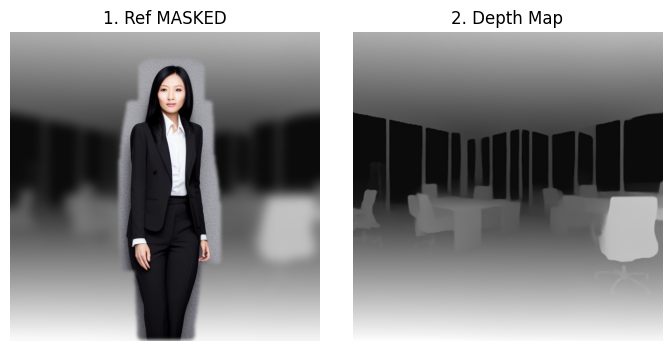

------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_1_NU_FINAL_IMAGE.png
--- HIỂN THỊ TẠM THỜI: Mask/Depth 2 ---


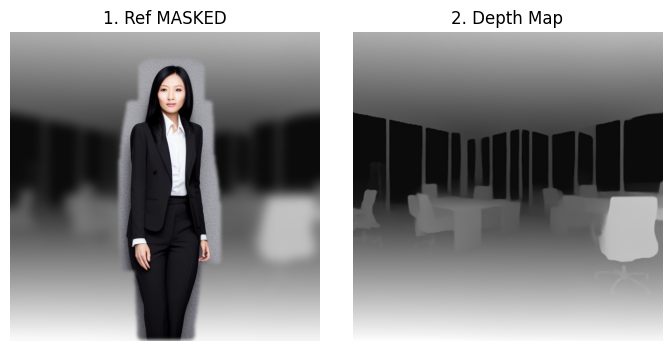

------------------------------


  0%|          | 0/35 [00:00<?, ?it/s]

-> Đã tạo và lưu ảnh: Final_Pose_2_NAM_FINAL_IMAGE.png


*** HIỂN THỊ KẾT QUẢ CUỐI CÙNG TỔNG HỢP ***


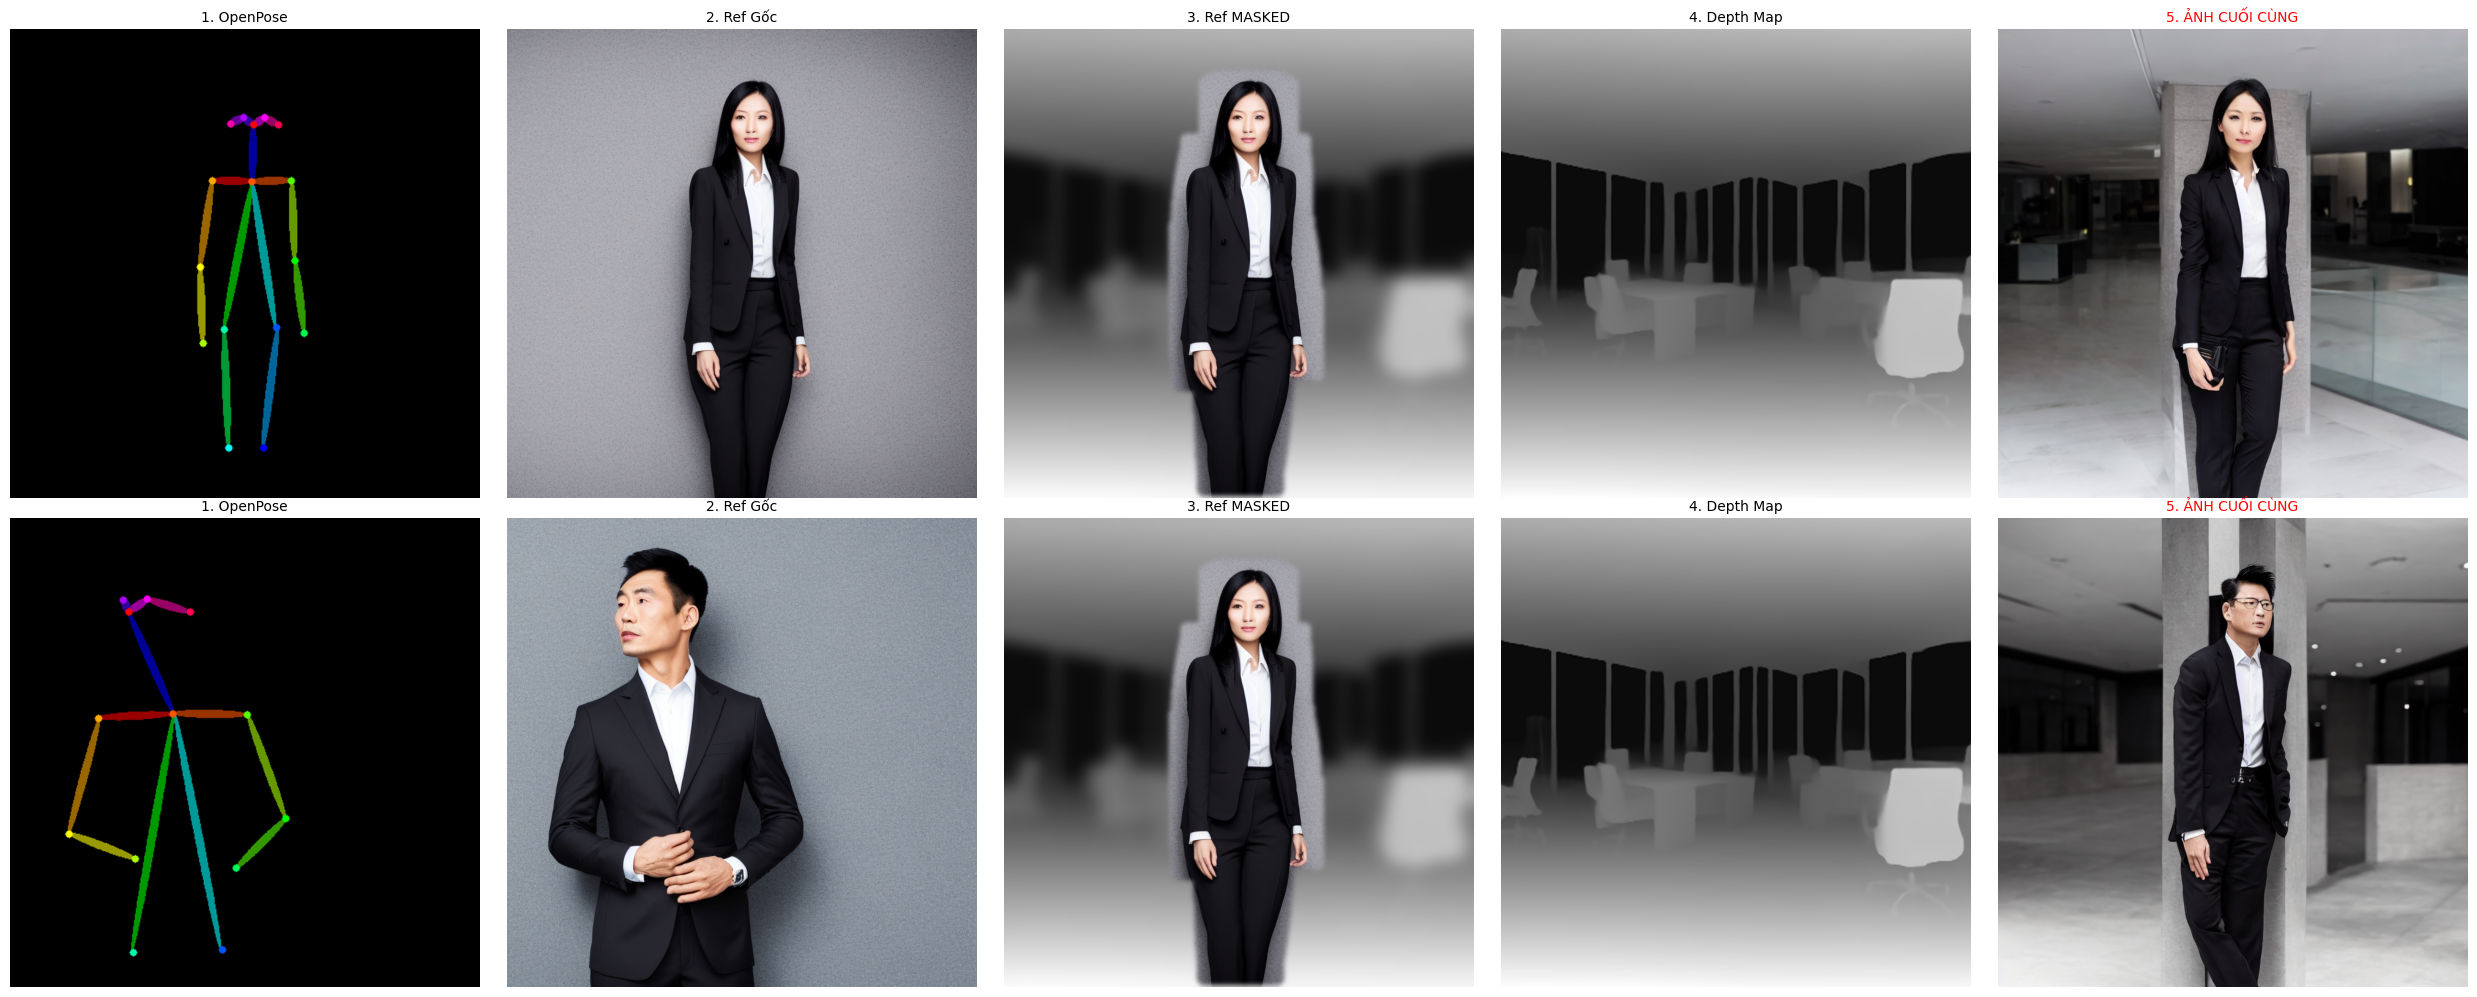


--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---
>>> DEBUG: Kiểm tra biến môi trường và file
OUTPUT_DIR: Pro_Auto_Pose_Output
CONSISTENCY_DIR: Pro_Consistency_Output
i2i_pipe is None? False
torch available, version: 2.8.0+cu126
device var in globals(): True
Files in OUTPUT_DIR (head): ['NAM_2_Action_Uniform_V2_base_image.png', 'NU_1_Action_Uniform_V2_openpose.png', 'NU_1_Action_Uniform_V2_base_image.png', 'NAM_2_Action_Uniform_V2_openpose.png', 'AI_Generated_Background.png']
NU_1_Action_Uniform_V2_openpose.png -> Pro_Auto_Pose_Output/NU_1_Action_Uniform_V2_openpose.png exists? True
NAM_2_Action_Uniform_V2_openpose.png -> Pro_Auto_Pose_Output/NAM_2_Action_Uniform_V2_openpose.png exists? True


In [61]:
# @title 4c. Xử Lý, Masking và Hiển Thị Kết Quả (Tối ưu hóa)
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# Giả định: globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP'],
# show_images (Cell 0), i2i_pipe (Cell 4a) đã được định nghĩa.


# --- THỰC HIỆN SẢN XUẤT ẢNH ---
PROMPT_MAP_FULL = [
    ("NU_1_Action_Uniform_V2_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Action_Uniform_V2_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
]


CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET VÀ MASKING...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ['OUTPUT_DIR'], pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"


        # TỐI ƯU HÓA HIỂN THỊ TẠM THỜI: Dùng plt.figure trực tiếp
        print(f"--- HIỂN THỊ TẠM THỜI: Mask/Depth {i+1} ---")
        plt.figure(figsize=(7.0, 3.5))
        plt.subplot(1, 2, 1)
        plt.imshow(MASKED_REF_IMAGE)
        plt.title(f"1. Ref MASKED", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(globals()['BG_DEPTH_MAP'])
        plt.title(f"2. Depth Map", fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print("-" * 30)

        generator = torch.Generator(device).manual_seed(200 + i)

        # GỌI DUAL CONTROLNET
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=MASKED_REF_IMAGE,
            control_image=[pose_image, globals()['BG_DEPTH_MAP']],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,
            strength=0.70,
            controlnet_conditioning_scale=[1.0, 1.5],
            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ TỔNG HỢP ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(os.environ['CONSISTENCY_DIR'], output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image, ref_image, masked_ref_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")

    # ----------------------------------------------------
    # --- HIỂN THỊ KẾT QUẢ CUỐI CÙNG (5 CỘT) ---
    # ----------------------------------------------------
    num_results = len(final_results)
    if num_results > 0:
        print("\n\n*** HIỂN THỊ KẾT QUẢ CUỐI CÙNG TỔNG HỢP ***")
        # 5 cột: OpenPose | Ref Gốc | Ref Masked | Depth Map | Final Image
        fig, axes = plt.subplots(num_results, 5, figsize=(25, 5 * num_results))
        axes = np.array(axes).ravel()

        if num_results == 1:
            axes = axes.reshape(1, 5)
        else:
            axes = axes.reshape(num_results, 5)

        for i, (prompt, pose_img, final_img, original_ref_img, masked_ref_img) in enumerate(final_results):
            # Cột 1: OpenPose
            axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"1. OpenPose", fontsize=10); axes[i, 0].axis('off')
            # Cột 2: Ref Gốc
            axes[i, 1].imshow(original_ref_img); axes[i, 1].set_title(f"2. Ref Gốc", fontsize=10); axes[i, 1].axis('off')
            # Cột 3: Ref MASKED
            axes[i, 2].imshow(MASKED_REF_IMAGE); axes[i, 2].set_title(f"3. Ref MASKED", fontsize=10); axes[i, 2].axis('off')
            # Cột 4: Depth Map
            axes[i, 3].imshow(globals()['BG_DEPTH_MAP']); axes[i, 3].set_title("4. Depth Map", fontsize=10); axes[i, 3].axis('off')
            # Cột 5: ẢNH CUỐI CÙNG
            axes[i, 4].imshow(final_img); axes[i, 4].set_title(f"5. ẢNH CUỐI CÙNG", fontsize=10, color='red'); axes[i, 4].axis('off')

        plt.tight_layout()
        plt.show()

    print("\n--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")


# Debug quick-check: in các biến quan trọng và liệt kê files trong OUTPUT_DIR
print(">>> DEBUG: Kiểm tra biến môi trường và file")
print("OUTPUT_DIR:", os.environ.get('OUTPUT_DIR'))
print("CONSISTENCY_DIR:", os.environ.get('CONSISTENCY_DIR'))
print("i2i_pipe is None?", i2i_pipe is None)
try:
    import torch
    print("torch available, version:", torch.__version__)
    print("device var in globals():", 'device' in globals())
except Exception as e:
    print("torch import err:", e)

out_dir = os.environ.get('OUTPUT_DIR')
if out_dir and os.path.exists(out_dir):
    print("Files in OUTPUT_DIR (head):", os.listdir(out_dir)[:50])
else:
    print("OUTPUT_DIR không tồn tại hoặc chưa set đúng.")

# Kiểm tra từng pose file path theo PROMPT_MAP_FULL
for pose_file, gender, _ in PROMPT_MAP_FULL:
    pose_path = os.path.join(os.environ.get('OUTPUT_DIR',''), pose_file)
    print(pose_file, "->", pose_path, "exists?", os.path.isfile(pose_path))


In [32]:
# @title 4. SẢN XUẤT ẢNH BẰNG DUAL CONTROLNET (FIX CUỐI: MASKING ẢNH REF VÀ HIỂN THỊ CHẮC CHẮN)

import torch
from diffusers import StableDiffusionImg2ImgPipeline, ControlNetModel
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display # Import để đảm bảo hiển thị hình ảnh

# Giả định các biến sau đã được thiết lập trong các Cell trước:
# device, model_id, globals()['REF_NU_IMAGE'], globals()['REF_NAM_IMAGE'], globals()['BG_DEPTH_MAP']
# os.environ['OUTPUT_DIR'], os.environ['CONSISTENCY_DIR']

# --- KHỞI TẠO PIPELINE (DUAL CONTROLNET) ---
try:
    # Tải ControlNet Model (Pose)
    pose_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16).to(device)
    # Tải ControlNet Model (Depth)
    depth_controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16).to(device)

    # Tải Pipeline với LIST ControlNet
    i2i_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        controlnet=[pose_controlnet, depth_controlnet] # LIST ControlNet Models
    ).to(device)
    if device == "cuda":
        # Tải lại Xformers nếu cần thiết
        try:
            i2i_pipe.enable_xformers_memory_efficient_attention()
        except Exception:
            pass # Bỏ qua lỗi nếu không thể kích hoạt
    print("Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).")
except Exception as e:
    print(f"!!! LỖI KHỞI TẠO DUAL PIPELINE: {e}")
    i2i_pipe = None

# --- HÀM TẠO MASK TRÊN ẢNH REF (FIX Lỗi Nền) ---
def create_masked_ref_image(ref_image, pose_image_path):
    """Sử dụng OpenPose Map để mask ảnh ref, che bối cảnh bằng màu trung tính."""

    # 1. Tải OpenPose Map
    pose_mask_img = Image.open(pose_image_path).convert("RGB")

    pose_mask_img = pose_mask_img.resize(ref_image.size, Image.NEAREST)

    # 2. Tạo Mask: Tìm các pixel có màu (xương/khớp), biến chúng thành mask
    mask_np = np.array(pose_mask_img)
    # Vùng có dữ liệu pose (Màu không phải đen [0,0,0])
    is_person = (mask_np[:, :, 0] > 0) | (mask_np[:, :, 1] > 0) | (mask_np[:, :, 2] > 0)

    # 3. Áp dụng Mask lên ảnh Ref
    ref_np = np.array(ref_image).copy()

    # Đặt vùng bối cảnh (không phải người) thành màu trung tính (Xám: 128)
    ref_np[~is_person] = 128

    return Image.fromarray(ref_np)

# --- THỰC HIỆN SẢN XUẤT ẢNH ---
PROMPT_MAP_FULL = [
    ("NU_1_Ref_openpose.png", "NU", "hands on hips, professional posture, full body pose"),
    ("NAM_2_Ref_openpose.png", "NAM", "hands deeply set in pants pockets, head tilted, defensive posture"),
    ("NU_3_NewPose_openpose.png", "NU", "looking at camera, one hand pointing directly"),
    ("NAM_4_NewPose_openpose.png", "NAM", "confident standing pose, leaning against a clean white desk"),
]
CONSISTENCY_PROMPT_NU = "A beautiful asian woman, 30 years old, high cheekbones, long black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
CONSISTENCY_PROMPT_NAM = "A handsome asian man, 35 years old, strong jawline, short black hair, in a very tailored black business suit, sharp focus, cinematic lighting, full body pose, centered"
NEG_PROMPT_FULL = "blurry, deformed, low quality, worst quality, ugly, out of frame, cropped, cut-off, half face, upper body shot, medium shot, close up, disembodied limbs, different clothing, different hair color, two people, different face, distracting objects, text, logos"

final_results = []
if i2i_pipe is not None:
    print(f"\nBẮT ĐẦU TẠO {len(PROMPT_MAP_FULL)} ẢNH VỚI DUAL CONTROLNET VÀ MASKING...")

    for i, (pose_file, gender, pose_description) in enumerate(PROMPT_MAP_FULL):
        pose_path = os.path.join(os.environ['OUTPUT_DIR'], pose_file)
        if not os.path.exists(pose_path): continue

        pose_image = Image.open(pose_path).convert("RGB").resize((768, 768))
        ref_image = globals()['REF_NU_IMAGE'] if gender == "NU" else globals()['REF_NAM_IMAGE']
        final_prompt = f"{CONSISTENCY_PROMPT_NU if gender == 'NU' else CONSISTENCY_PROMPT_NAM}, {pose_description}"

        # BƯỚC MASKING CHỦ ĐỘNG
        masked_ref_image = create_masked_ref_image(ref_image, pose_path)

        generator = torch.Generator(device).manual_seed(200 + i)

        # GỌI DUAL CONTROLNET
        generated_image = i2i_pipe(
            prompt=final_prompt,
            image=masked_ref_image, # <-- Dùng ảnh đã được che nền
            control_image=[pose_image, globals()['BG_DEPTH_MAP']],
            negative_prompt=NEG_PROMPT_FULL,
            num_inference_steps=50,
            guidance_scale=9.0,

            strength=0.70, # Giữ mức này để giữ nhân vật, nhưng bối cảnh đã bị che sẽ dễ dàng thay đổi
            controlnet_conditioning_scale=[1.0, 1.5], # Tăng cường ảnh hưởng của Depth Map

            generator=generator
        ).images[0]

        # --- LƯU KẾT QUẢ VÀ TỔNG HỢP ---
        output_filename = f"Final_Pose_{i+1}_{gender}_FINAL_IMAGE.png"
        final_output_path = os.path.join(os.environ['CONSISTENCY_DIR'], output_filename)
        generated_image.save(final_output_path)
        final_results.append((final_prompt, pose_image, generated_image, masked_ref_image))
        print(f"-> Đã tạo và lưu ảnh: {output_filename}")

    # ----------------------------------------------------
    # --- HIỂN THỊ KẾT QUẢ CUỐI CÙNG (SỬ DỤNG IPython.display) ---
    # ----------------------------------------------------
    num_results = len(final_results)
    if num_results > 0:

        # Thay đổi số cột thành 4 để hiển thị thêm ảnh REF GỐC
        fig, axes = plt.subplots(num_results, 4, figsize=(20, 5 * num_results))
        # Xử lý trường hợp chỉ có 1 kết quả
        axes = np.array(axes).reshape(-1, 4)

        for i, (prompt, pose_img, final_img, masked_ref_img) in enumerate(final_results):
            axes[i, 0].imshow(pose_img); axes[i, 0].set_title(f"Tư thế {i+1} (OpenPose)", fontsize=10); axes[i, 0].axis('off')
            axes[i, 1].imshow(masked_ref_img); axes[i, 1].set_title(f"Ref Image (Đã MASK Bối cảnh)", fontsize=10); axes[i, 1].axis('off')
            # Thêm ảnh Depth Map (từ biến toàn cục) vào cột 3
            axes[i, 2].imshow(globals()['BG_DEPTH_MAP']); axes[i, 2].set_title("Depth Map Bối cảnh", fontsize=10); axes[i, 2].axis('off')
            axes[i, 3].imshow(final_img); axes[i, 3].set_title(f"ẢNH CUỐI CÙNG", fontsize=10, color='red'); axes[i, 3].axis('off')

        plt.tight_layout()

        # SỬA LỖI KHÔNG HIỂN THỊ
        display(fig)
        plt.close(fig) # Đóng figure

    print("\n--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---")
else:
    print("!!! KHÔNG THỂ CHẠY CELL 4 DO LỖI KHỞI TẠO PIPELINE. !!!")


Keyword arguments {'controlnet': [ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Đã tải DUAL ControlNet Pipeline (OpenPose + Depth).

BẮT ĐẦU TẠO 4 ẢNH VỚI DUAL CONTROLNET VÀ MASKING...

--- HOÀN TẤT CELL 4: SẢN XUẤT VÀ HIỂN THỊ THÀNH CÔNG ---
